# LightGBM Baseline Model

make models for each route(A, B, C, D) and prediction period(predict 2 weeks ahead, 4 weeks ahead, ...)

## Dateset
- [diff value from previous day](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/2) of [rolling mean over days](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/4)
## Target Variable
- vel_l values X weeks ahead (X = 2,4,6,8)
## Features

- track variables
  - present lev_l value
  - mean and variance of recent lev_l value
  - mean and variance of recent days and whole year values of track data
- equipment variables
  - row value of equipment variables
- seasonal variables
  - date (encoded by trigonometric function)
  - holiday dummy

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin
%matplotlib inline
# from utils import data_process as dp

In [2]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [3]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [4]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    track_df['kilo'] = track_df['kilo'].astype('str')
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [5]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    equ_df['kilo'] = equ_df['kilo'].astype('str')
    equ_df['sleeper_type'] = equ_df['sleeper_type'].replace(sleeper_type_dict).astype('category')
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [6]:
# degrade data types to save memory
def degrade_dtypes(df):
    for col in df.columns:
        if df[col].dtype=='int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype=='float64':
            df[col] = df[col].astype('float32')
    return df

In [7]:
abcd = 'a'

In [8]:
track = read_track(abcd)
track = degrade_dtypes(track)
equ = read_equ(abcd)
equ = degrade_dtypes(equ)

track_A shape: (10185690, 9)
equ_A shape: (27906, 9)


In [9]:
# sample_submit = pd.read_csv(os.path.join(input_dir, 'sample_submit.csv'), header=None)
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
index_master['kilo'] = index_master['kilo'].astype('str')

## Data Processing

In [10]:
# Drop outliers of line_name "A" (out of 2 sigma for each kilo)
def drop_outliers(track):
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')

    lev_pv_norm = (lev_pv - lev_pv.mean()) / lev_pv.std()
    lev_pv_norm_isnot_outlier = lev_pv_norm.abs() < 2
    lev_pv_shaved_tmp = lev_pv * lev_pv_norm_isnot_outlier
    lev_pv_shaved = lev_pv_shaved_tmp.replace(0.0, np.nan)
    lev_shaved = pd.melt(lev_pv_shaved.reset_index(), id_vars='date', value_name='lev_l')  
    track_new = lev_shaved.merge(track.drop('lev_l', axis=1), how='left', on=['date', 'kilo'])
    return track_new

In [11]:
if abcd=='a':
    track = drop_outliers(track)

/home/kuriyama/miniconda3/envs/rail_level_gap/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


### rolling average, diff

In [12]:
# rolling average params
roll_params = {
    'A': {'window': 21, 'min_periods': 14},
    'B': {'window': 14, 'min_periods': 7},
    'C': {'window': 14, 'min_periods': 7},
    'D': {'window': 14, 'min_periods': 7}
}

In [13]:
def roll_pv(track, abcd):
    # pivot: row is date, col is kilo
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')
    # rolling average
    lev_pv_ra = lev_pv.rolling(**roll_params[abcd.upper()], center=False, axis=0).mean()
    return lev_pv_ra

In [14]:
lev_pv_ra = roll_pv(track, abcd)

In [15]:
# diff
lev_pv_ra_diff = lev_pv_ra.diff()
# reverse pivot
lev_ra_diff = pd.melt(lev_pv_ra_diff.reset_index(), id_vars='date', value_name='lev_l_diff')  

## Target variable

In [16]:
def make_tgt(lev_ra_diff):
    lev_ra_diff_tgt_tmp = lev_ra_diff.copy()
    lev_ra_diff_tgt_tmp['date_tgt'] = lev_ra_diff_tgt_tmp['date']
    lev_ra_diff_tgt_tmp['date'] = lev_ra_diff_tgt_tmp['date'] - datetime.timedelta(days=1)
    lev_ra_diff_tgt = lev_ra_diff_tgt_tmp.rename(columns={'lev_l_diff': 'lev_l_diff_tgt'})
    return lev_ra_diff_tgt

In [17]:
lev_ra_diff_tgt = make_tgt(lev_ra_diff)

## Feature processing

In [18]:
def whole_mean(track):
    track_whole_mean = track.groupby('kilo').mean()
    track_whole_mean.columns = [i + '_w_mean' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [19]:
def whole_std(track):
    track_whole_mean = track.groupby('kilo').std()
    track_whole_mean.columns = [i + '_w_std' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [20]:
track_whole_mean = whole_mean(track)
track_whole_std = whole_std(track)
track_diff_whole_mean = whole_mean(lev_ra_diff)
track_diff_whole_std = whole_std(lev_ra_diff)

## Merge Dataset

In [21]:
def make_day_cnts(df):
    # May is bitween hottest day and coldest one
    day_cnts = df['date'] - datetime.datetime(2017, 5, 1)
    return day_cnts.dt.days

In [22]:
def merge_features_by_kilo(df):
    df = df.merge(track_whole_mean, on='kilo')
    df = df.merge(track_whole_std, on='kilo')
    df = df.merge(track_diff_whole_mean, on='kilo')
    df = df.merge(track_diff_whole_std, on='kilo')
    df = df.merge(equ, on='kilo')
    return df

In [23]:
# copy target df
data_all_tmp = lev_ra_diff_tgt.copy()
# merge features
data_all_tmp = data_all_tmp.merge(lev_ra_diff, on=['date', 'kilo'])
data_all_tmp = data_all_tmp.merge(track[['date', 'kilo', 'lev_l']], on=['date', 'kilo'])

# sin_date represents temperature
data_all_tmp['sin_date'] = np.sin(2 * np.pi * make_day_cnts(data_all_tmp) / 365)

data_all_tmp = merge_features_by_kilo(data_all_tmp)

data_all_tmp = data_all_tmp.dropna(how='any', axis=0, subset=['lev_l_diff_tgt', 'lev_l_diff'])

data_all = data_all_tmp#.query('date<"2018-03-19"')
del data_all_tmp
# del lev_ra_diff_tgt, lev_ra_diff, track_whole_mean, data_all_tmp, track, equ

In [24]:
# keep the oreder of X columns
global data_all_col_order
data_all_col_order = data_all.columns

## Make Dataset

In [25]:
def X_y_split(data, tgt_col='lev_l_diff_tgt', index_cols=['date', 'date_tgt', 'kilo']):
    data = data.set_index(index_cols)
    y = data[tgt_col]
    X = data.drop(tgt_col, axis=1)
    return X, y

In [26]:
# split train and test
is_val = (make_day_cnts(data_all) % 8)==0
X_dev, y_dev = X_y_split(data_all[is_val==False])
X_val, y_val = X_y_split(data_all[is_val==True])

## Train

In [27]:
hyperopt_params = {
    'bagging_freq': hp.uniform('bagging_freq', 0, 15),
    'feature_fraction': hp.uniform('feature_fraction', 0.05, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.75),
    'min_child_samples': hp.uniform('min_child_samples', 300, 600),
    'num_leaves': hp.uniform('num_leaves', 10, 500),
}

In [28]:
fit_params = {
    'early_stopping_rounds':30,
    'eval_set':[(X_val, y_val)],
    'eval_metric': 'mean_absolute_error',
    'verbose': False
}

In [29]:
# float to int
tobe_int_params = ['num_leaves', 'min_child_samples', 'bagging_freq']
def int_param_encoder(params):
    for param in tobe_int_params:
        if param in params:
            params[param] = int(params[param])
    return params

In [30]:
num_evals_i = 0
def objective(hyperopt_params):
    # パラメータを適切な型(int)に変換
    hyperopt_params = int_param_encoder(hyperopt_params)
    # モデルのインスタンス化
    model = lgb.LGBMRegressor(**hyperopt_params, objective='mean_absolute_error', n_estimators=1000, random_state=0)
    # trainデータを使ってモデルの学習
    model.fit(X_dev, y_dev, **fit_params)
    # validationデータを使用して、ラベルの予測
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
    # 予測ラベルと正解ラベルを使用してMAEを計算
    mae_score = mean_absolute_error(y_val, y_val_pred)
    global num_evals_i
    num_evals_i += 1
    print('[{num_evals}] best_ite: {best_ite}\tMAE: {mae_score}'.format(num_evals=str(num_evals_i).zfill(4), mae_score=mae_score, best_ite=model.best_iteration_))
    return mae_score

In [31]:
# iterationする回数
max_evals = 100
# 試行の過程を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する値を定義した関数
    fn=objective,
    # 探索するパラメータのdictもしくはlist
    space=hyperopt_params,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    rstate=np.random.RandomState(0)
)

[0001] best_ite: 3	MAE: 0.034997725396868205
[0002] best_ite: 1	MAE: 0.034191236069837705
[0003] best_ite: 4	MAE: 0.0345171750043142
[0004] best_ite: 3	MAE: 0.03441290902264476
[0005] best_ite: 1	MAE: 0.03438272004875318
[0006] best_ite: 2	MAE: 0.03450850353472799
[0007] best_ite: 1	MAE: 0.03447255633096908
[0008] best_ite: 3	MAE: 0.0345778104316189
[0009] best_ite: 2	MAE: 0.03482773259798838
[0010] best_ite: 2	MAE: 0.034253799440012535
[0011] best_ite: 1	MAE: 0.03423289394116276
[0012] best_ite: 1	MAE: 0.03433253306500767
[0013] best_ite: 1	MAE: 0.03444813736430732
[0014] best_ite: 1	MAE: 0.0342510534309923
[0015] best_ite: 1	MAE: 0.03429572014786742
[0016] best_ite: 1	MAE: 0.03427715189011259
[0017] best_ite: 2	MAE: 0.034335515717266556
[0018] best_ite: 5	MAE: 0.03425716938392636
[0019] best_ite: 2	MAE: 0.03419102385373955
[0020] best_ite: 1	MAE: 0.034359637726612414
[0021] best_ite: 1	MAE: 0.034250749399414956
[0022] best_ite: 18	MAE: 0.03424022070273708
[0023] best_ite: 1	MAE: 0.03

In [32]:
int_param_encoder(best)

{'bagging_freq': 13,
 'feature_fraction': 0.690733230152089,
 'learning_rate': 0.27423142822411006,
 'min_child_samples': 547,
 'num_leaves': 174}

In [33]:
best_params = int_param_encoder(best)
model = lgb.LGBMRegressor(**best_params, objective='mean_absolute_error', n_estimators=1000, random_state=0)
model.fit(X_dev, y_dev, **fit_params)

LGBMRegressor(bagging_freq=13, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.690733230152089,
       importance_type='split', learning_rate=0.27423142822411006,
       max_depth=-1, min_child_samples=547, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=174,
       objective='mean_absolute_error', random_state=0, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [34]:
with open(os.path.join(output_dir, 'lgbm_baseline_20181207_model_{}.pkl'.format(abcd.upper())), mode='wb') as f:
    pickle.dump(model, f)
    
with open(os.path.join(output_dir, 'lgbm_baseline_20181207_model_{}.pkl'.format(abcd.upper())), mode='rb') as f:
    model = pickle.load(f)

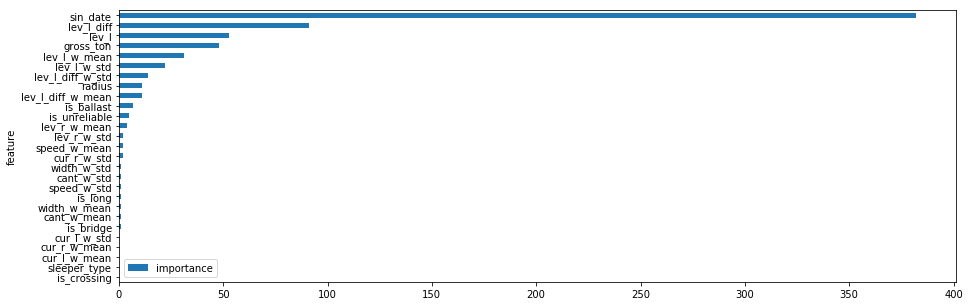

In [35]:
feature_importance = pd.DataFrame({'feature': X_dev.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance').set_index('feature', drop=False)
ax = feature_importance.plot.barh(figsize=(15,5))

## Predict for Submission
1. make initial values using last date lev_l_diff of each kilo
2. predict 2 weeks ahead lev_l values by the initial values
3. predcit 4 weeks ahead lev_l values by the 2 weeks ahead lev_l values
4. repeat ...

### make initial values for future prediction

In [36]:
def make_last_date_pv(pv_df):
    last_date_pv_df = pv_df.fillna(method='ffill').tail(1)
    last_date_pv_df = last_date_pv_df.fillna(method='ffill', axis=1)
    return last_date_pv_df

def melt_pv(pv_df, value_name):
    return pd.melt(pv_df.reset_index(), id_vars='date', value_name=value_name)

### Repeat prediction and making datasets

In [37]:
# predict y
# y -> X_next_01
# X_next_01 -> y_next_02
# y_next_02-> X_next_02
# X_next_02 -> y_next_03 ...

In [38]:
def make_data_all_nxt(y_nxt, y_nxt_undiff):
    data_all_nxt = y_nxt.copy()
    data_all_nxt = data_all_nxt.merge(y_nxt_undiff, on=['date', 'kilo'], how='left')
    data_all_nxt['sin_date'] = np.sin(2 * np.pi * make_day_cnts(data_all_nxt) / 365)
    data_all_nxt = merge_features_by_kilo(data_all_nxt)
    data_all_nxt['date_tgt'] = data_all_nxt['date'] + datetime.timedelta(days=1)
    data_all_nxt['lev_l_diff_tgt'] = -1.0
    return data_all_nxt[data_all_col_order]

def make_y_nxt(data_all_current, model):
    X_current, y_ = X_y_split(data_all_current)
    y_nxt_np = model.predict(X_current)
    y_nxt = pd.Series(data=y_nxt_np, index=y_.index, name=y_.name)
#     y_nxt = y_nxt.rolling(5, min_periods=0, center=True).mean()
    y_nxt = y_nxt.reset_index(level=['date_tgt', 'kilo']).reset_index(drop=True)
    y_nxt = y_nxt.rename(columns={'date_tgt': 'date', 'lev_l_diff_tgt': 'lev_l_diff'})
    
    y_nxt_undiff = data_all_current[['date', 'kilo', 'lev_l']].copy()
    y_nxt_undiff['date'] = y_nxt_undiff['date'] + datetime.timedelta(days=1)
    y_nxt_undiff = y_nxt.merge(y_nxt_undiff, on=['date', 'kilo'], how='left')
    y_nxt_undiff['lev_l'] = y_nxt_undiff['lev_l'] + y_nxt_undiff['lev_l_diff']
    y_nxt_undiff = y_nxt_undiff[['date', 'kilo', 'lev_l']]
    return y_nxt, y_nxt_undiff

In [39]:
def predict4submission(lev_pv_ra_diff, lev_pv_ra, model):
    last_date_lev_ra_diff = melt_pv(make_last_date_pv(lev_pv_ra_diff), 'lev_l_diff')
    last_date_lev_ra = melt_pv(make_last_date_pv(lev_pv_ra), 'lev_l')
    last_date_lev_ra['lev_l'] = last_date_lev_ra['lev_l'] + last_date_lev_ra_diff['lev_l_diff']

    y_nxt_pool = y_nxt = last_date_lev_ra_diff
    y_nxt_undiff_pool = y_nxt_undiff = last_date_lev_ra
    for i in range(110): # 2week * 7 > 91days
        data_all_nxt = make_data_all_nxt(y_nxt, y_nxt_undiff)
        y_nxt, y_nxt_undiff = make_y_nxt(data_all_nxt, model)
        y_nxt_pool = pd.concat([y_nxt_pool, y_nxt], axis=0)
        y_nxt_undiff_pool = pd.concat([y_nxt_undiff_pool, y_nxt_undiff], axis=0)
    return y_nxt_undiff_pool

### Validation

In [40]:
y_nxt_undiff_pool_val = predict4submission(lev_pv_ra_diff.query('date<"2017-04-21"'), lev_pv_ra.query('date<"2017-04-21"'), model)
y_nxt_undiff_pool_val = y_nxt_undiff_pool_val.rename(columns={'lev_l': 'lev_l_pred'})

tru_pred_df = y_nxt_undiff_pool_val.merge(track, how='inner', on=['date', 'kilo'])
tru_pred_df = tru_pred_df[['date', 'kilo', 'lev_l', 'lev_l_pred']]
tru_pred_df = tru_pred_df.dropna()
print('sample: {:,}'.format(tru_pred_df.shape[0]))
print('MAE: {}'.format(mean_absolute_error(tru_pred_df['lev_l'], tru_pred_df['lev_l_pred'])))

sample: 2,460,616
MAE: 0.36007558901909087


## Submission

In [41]:
y_nxt_undiff_pool = predict4submission(lev_pv_ra_diff.query('date<"2018-03-19"'), lev_pv_ra.query('date<"2018-03-19"'), model)
index_master_abcd = index_master.query('line_name=="{}"'.format(abcd.upper()))
pred_df = index_master_abcd.merge(y_nxt_undiff_pool, how='left', on=['date', 'kilo'])
pred_df = pred_df.rename(columns={'lev_l': 'lev_l_pred'})
pred_df = pred_df.drop('id', axis=1)

In [42]:
pred_df.to_csv(os.path.join(output_dir, 'lgbm_baseline_20181207_{}.csv'.format(abcd.upper())), index=False)

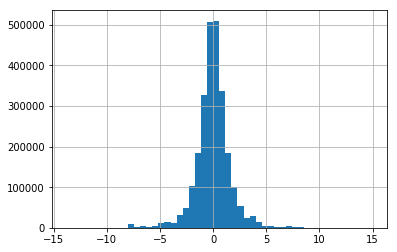

In [43]:
pred_df['lev_l_pred'].hist(bins=50)

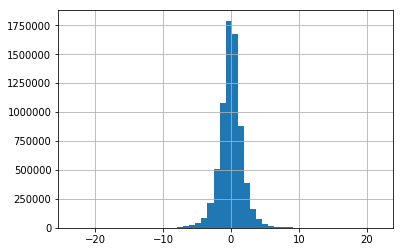

In [44]:
track['lev_l'].hist(bins=50)